In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import skew, norm, probplot # TODO skew, norm, probplot
import time
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures # TODO RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression #TODO sklearn.feature_selection, Ridge, HuberRegressor
from sklearn.svm import SVR #TODO svm, SVR
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor #TODO mlxtend.regressor


In [2]:
df = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [3]:
y = df['SalePrice']
df = df.drop(['SalePrice'],axis=1)
df = df.set_index('Id')
test = test.set_index('Id')

--------------------------
Total columns with null:
34
--------------------------
Total null values:
13965
--------------------------


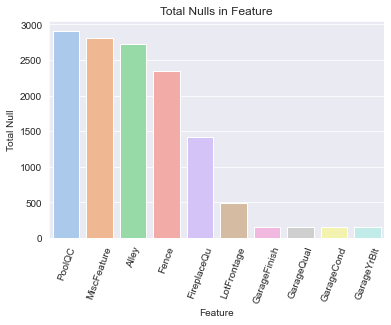

In [4]:
null_list = []
for col in df.columns:
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 or test_null != 0:
        null_list.append([col,null,test_null])
null_df = pd.DataFrame(null_list,columns=['Feature','Null','Test Null'])
null_df.set_index('Feature')
null_df['Total Null'] = null_df['Null'] + null_df['Test Null']
print("--------------------------")
print("Total columns with null:")
print(len(null_df))
print("--------------------------")
print("Total null values:")
print(null_df['Total Null'].sum(axis=0))
print("--------------------------")
sns.set_palette(sns.color_palette("pastel"))
sns.barplot(data=null_df.sort_values(by='Total Null', ascending = False).head(10), x='Feature',y='Total Null')
plt.xticks(rotation = 70)
plt.title('Total Nulls in Feature')
plt.show()

### MSZoning 전처리

In [5]:
full = pd.concat([df,test],axis=0).reset_index(drop=True)

,Neighborhood,MSZoning
Id,,
1916,IDOTRR,NaN
2217,IDOTRR,NaN
2251,IDOTRR,NaN
2905,Mitchel,NaN


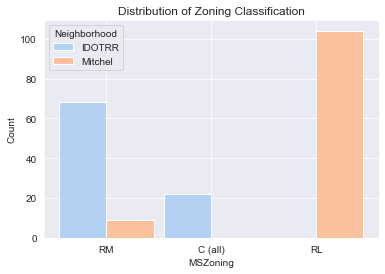

In [6]:
null = test[test['MSZoning'].isnull()][['Neighborhood','MSZoning']]
display(null)
plot_data = pd.concat([full[full['Neighborhood'] == 'IDOTRR'], full[full['Neighborhood'] == 'Mitchel']], axis=0)
sns.histplot(data=plot_data, x='MSZoning', hue = 'Neighborhood', multiple='dodge', shrink=.9) #TODO hue : 유형 분류란 multiple : 같은 항목 내 도표의 표시방법 ('dodge': 각각의 막대를 따로 표시) shrink : 막대 폭 조절
plt.title('Distribution of Zoning Classification')
plt.show()

In [7]:
full['MSZoning'].value_counts()

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

위의 결과로부터 MSZoning값과 Neighborhood와의 상관관계가 얻어졌으므로 MSZoning의 결측치 보완에 사용한다.

In [8]:
test.loc[(test['Neighborhood'] == 'IDOTRR') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RM'
test.loc[(test['Neighborhood'] == 'Mitchel') & (test['MSZoning'].isnull()), 'MSZoning'] = 'RL'

### LotFrontage 전처리

부동산으로부터의 선형거리를 나타낸 값으로, LotArea와 어느정도 상관관계가 있을 것으로 예상된다. 따라서 결측값을 대체하기 위해 선형회귀를 사용한다.
또한, 데이터에서 이상치를 수동으로 필터링한다.

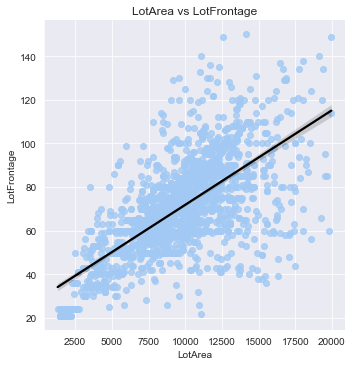

In [9]:
data = full[(~full['LotFrontage'].isnull()) & (full['LotFrontage'] <= 150) & (full['LotArea'] <= 20000)]
sns.lmplot(data=data, x='LotArea', y='LotFrontage', line_kws={'color': 'black'})
plt.ylabel('LotFrontage')
plt.xlabel('LotArea')
plt.title('LotArea vs LotFrontage')
plt.show()

In [10]:
area_vs_frontage = LinearRegression()
area_vs_frontage_X = data['LotArea'].values.reshape(-1, 1)
area_vs_frontage_y = data['LotFrontage'].values
area_vs_frontage.fit(area_vs_frontage_X,area_vs_frontage_y)
for table in [df,test]:
    table['LotFrontage'].fillna(area_vs_frontage.intercept_ + table['LotArea'] * area_vs_frontage.coef_[0], inplace=True)

Alley : 데이터 설명에 따르면 NA값은 접근 가능한 골목이 없다는 의미인 듯 하므로 null값을 None으로 변경해도 괜찮을 듯 하다.

In [11]:
for table in [df,test]:
    table['Alley'].fillna('None',inplace=True)

Utilities : 수도, 전기, 가스, 하수 등의 유틸리티 이용성. 일반적으로 모두 사용 가능하므로 결측치를 AllPub로 대체 가능할 듯.

In [12]:
full['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [13]:
test['Utilities'].fillna('AllPub', inplace=True)

NoSeWa 항목은 그냥 빼버리는것이 나을 듯 하다. test항목에 NoSeWa가 없는데 학습시켜봤자 과적합만 일으킬 수 있으므로.

In [14]:
df.drop(df[df['Utilities'] == 'NoSeWa'].index, inplace=True)

Exterior 과 관련된 항목은 10가지 이상이 있다(외장재). 하지만 대부분 비닐로 구성되어있으므로 결측치는 비닐로 대체하는 것으로 한다.

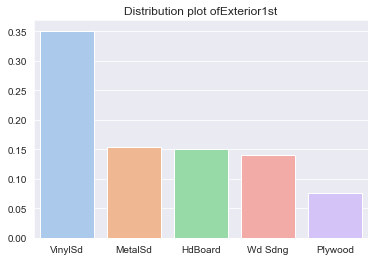

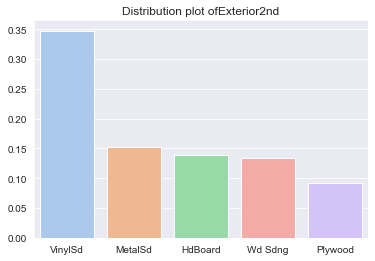

In [15]:
for metrics in ['Exterior1st','Exterior2nd']:
    table = full[metrics].value_counts(normalize=True).head() #TODO normalize 왜하는거임?
    sns.barplot(x=table.index,y=table.values)
    plt.title('Distribution plot of' + metrics)
    plt.show()


In [16]:
test['Exterior1st'] = test['Exterior1st'].fillna(full['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(full['Exterior2nd'].mode()[0])

MasVnrType : 석조외장(주로벽돌)을 나타내는 항목으로, NA값은 석조외장이 없다는 의미이다. 하지만 이번 데이터에서 test set에 masvnrtype은 없는데 masvnrarea는 있는 항목을 발견하였으므로 다른값으로 대체한다.

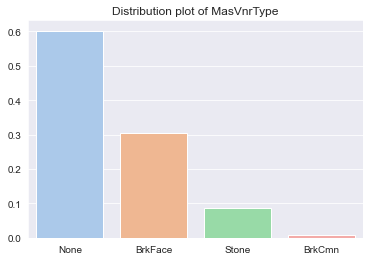

In [17]:
table = full['MasVnrType'].value_counts(normalize=True).head()
sns.barplot(x=table.index, y=table.values)
plt.title('Distribution plot of MasVnrType')
plt.show()

약 60%가 석조외장이 없다고 답했으므로 결측치는 이것으로 대체한다

In [18]:
test['MasVnrType'][2611] = 'BrkFace' # Area는 있는데 Type은 결측치인 값 대체
test['MasVnrType'] = test['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)
df['MasVnrType'] = df['MasVnrType'].fillna(full['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)


Basement Metrics : 지하실면적과 관련있는 항목이다. 그런데 항목 중 지하실이 있는데 면적이 0 인 것이 있으므로 다른 값으로 대체한다.

In [19]:
for basement_metrics_cols in ['BsmtExposure','BsmtCond','BsmtQual']:
    if len(full[(full[basement_metrics_cols].notnull()) & (full['BsmtFinType1'].isnull())]) > 0:
        print('Present with BsmtFinType1 but undetected' + basement_metrics_cols)
        display(full[(full[basement_metrics_cols].notnull()) & (full['BsmtFinType1'].isnull())])

In [20]:
for basement_metrics_cols in ['BsmtExposure','BsmtCond','BsmtQual']:
    if len(full[(full[basement_metrics_cols].isnull()) & (full['BsmtFinType1'].notnull())]) > 0:
        print('\nPresent with ' + basement_metrics_cols + ' but BsmtFinType1 undetected')
        display(full[(full[basement_metrics_cols].isnull()) & (full['BsmtFinType1'].notnull())])


Present with BsmtExposure but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
948,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Normal
1487,20,RL,73.0,8987,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
2348,60,FV,81.0,10411,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,7,2007,New,Partial



Present with BsmtCond but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2040,20,RL,103.0,16280,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,5,2008,WD,Normal
2185,20,RL,65.0,6500,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal
2524,80,RL,72.0,9720,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal



Present with BsmtQual but BsmtFinType1 undetected


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2217,70,C (all),60.0,5280,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
2218,50,C (all),52.0,5150,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


In [21]:
# bsmtexposure값이 null 이고 type은 존재하는 값의 null 값을 'no'로 대체하기로 함.
df.loc[((df['BsmtExposure'].isnull()) & (df['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
test.loc[((test['BsmtExposure'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtExposure'] = 'No'
# bsmtcond 결측치를 가장 흔한값으로 대체
test.loc[((test['BsmtCond'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtCond'] = 'TA'
# bsmtqual 결측치를 가장 흔한값으로 대체
test.loc[((test['BsmtQual'].isnull()) & (test['BsmtFinType1'].notnull())), 'BsmtQual'] = 'TA'


In [22]:
test[test['BsmtFinSF1'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,...,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml


bsmtfinsf1항목이 결측치인 경우 면적데이터는 0으로 설정한다.

In [23]:
for square_feet_metrics in ['TotalBsmtSF','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']:
    test[square_feet_metrics][2121] = 0

In [24]:
test[test['BsmtFullBath'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,FR3,...,0,0,NaN,MnPrv,NaN,0,4,2008,ConLD,Abnorml
2189,20,RL,123.0,47007,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal


In [25]:
for bathroom_metrics in ['BsmtFullBath','BsmtHalfBath']:
    test[bathroom_metrics][2121] = 0
    test[bathroom_metrics][2189] = 0

In [26]:
for table in [df,test]:
    table[table.columns[table.columns.str.contains('Bsmt')]] = table[table.columns[table.columns.str.contains('Bsmt')]].fillna("None") #TODO .columns[] 대괄호가 오는 경우 조건 탐색 가능함

Electrical,Functional and Kitchen Quality : 이 세 값들도 mode value로 결측치를 대체한다.

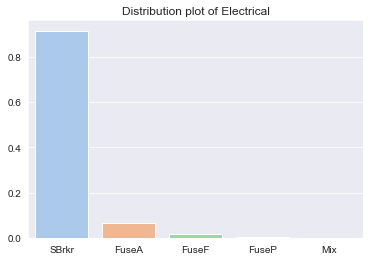

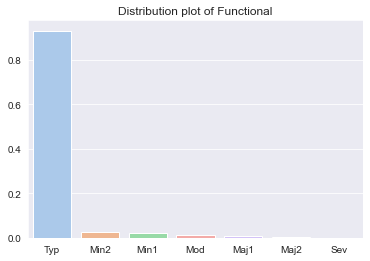

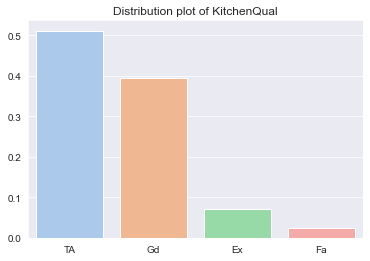

In [27]:
for metrics in ['Electrical','Functional','KitchenQual']:
    table = full[metrics].value_counts(normalize=True)
    sns.barplot(x=table.index,y=table.values)
    plt.title('Distribution plot of ' + metrics)
    plt.show()

In [28]:
df['Electrical'].fillna('SBrkr',inplace=True)
test['Functional'].fillna('Typ',inplace=True)
test['KitchenQual'].fillna('TA',inplace=True)

In [29]:
full[full['GarageCars'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2576,70,RM,50.0,9060,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca


In [30]:
test['GarageCars'].fillna(0,inplace=True)
test['GarageArea'].fillna(0,inplace=True)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
2489,20,RL,85.0,13770,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,10,2007,NaN,Normal


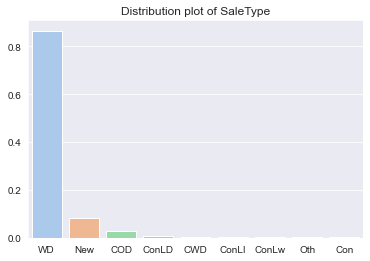

In [31]:
display(full[full['SaleType'].isnull()])
table = full['SaleType'].value_counts(normalize=True)
sns.barplot(x=table.index,y=table.values)
plt.title('Distribution plot of SaleType')
plt.show()

SaleType항목도 결측치에 mode값인 WD를 대입하자.

In [32]:
test['SaleType'].fillna('WD', inplace=True)

이제 결측치가 있는지 다시 전체적으로 확인해보자

--------------------------
Total columns with null:
9
--------------------------
Total null values:
10281
--------------------------


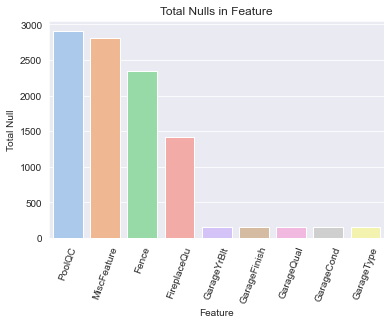

In [33]:
null_list = []
for col in df.columns:
    null = df[col].isnull().sum()
    test_null = test[col].isnull().sum()
    if null != 0 or test_null != 0:
        null_list.append([col,null,test_null])
null_df = pd.DataFrame(null_list,columns=['Feature','Null','Test Null'])
null_df.set_index('Feature')
null_df['Total Null'] = null_df['Null'] + null_df['Test Null']
print("--------------------------")
print("Total columns with null:")
print(len(null_df))
print("--------------------------")
print("Total null values:")
print(null_df['Total Null'].sum(axis=0))
print("--------------------------")
sns.set_palette(sns.color_palette("pastel"))
sns.barplot(data=null_df.sort_values(by='Total Null', ascending = False).head(10), x='Feature',y='Total Null')
plt.xticks(rotation = 70)
plt.title('Total Nulls in Feature')
plt.show()

나머지 결측치에 대해서는 0 또는 none으로 채운다

In [34]:
df['GarageYrBlt'].fillna(0,inplace=True)
test['GarageYrBlt'].fillna(0,inplace=True)
df.fillna('None',inplace=True)
test.fillna('None',inplace=True)

In [35]:
df.isnull().sum().sum() + test.isnull().sum().sum()

0

In [36]:
df.index = df.index - 1

### Feature Engineering

Log-transformation은 feature값이 공평하게 다뤄지도록 가공하는 주요한 방법들 중 하나이다.

feature값들을 공평항게 다루는 이유는 클래스 분류가 편향된 값들이 모델작성에 미치는 영향을 줄이기 위해서이다.


 mu = 180921.20 and sigma = 79415.29



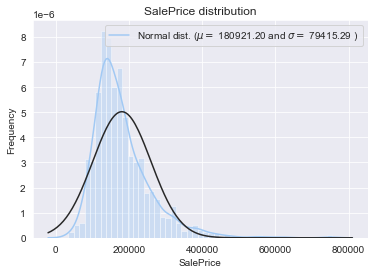

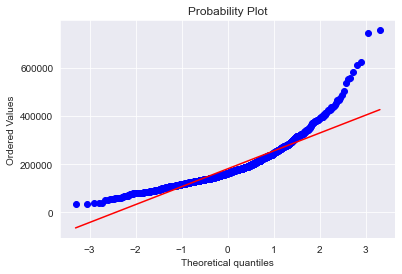

In [37]:
# Distribution plot
sns.distplot(y, fit=norm)

(mu, sigma) = norm.fit(y) #TODO mu, sigma가 뭘 뜻하는지?
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

## QQ-plot ##TODO QQ-plot이 뭐임?
fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

첫번째 플롯은 타겟변수의 분포를 정규분포와 비교한 것이다. 정규분포에 비해 오른쪽으로 꼬리가 긴 것을 확인할 수 있다.

QQ plot은 정규분포와 실제분포의 분위 분포를 나타낸 것이다 (? 사실 아직 잘 모르겠음)

이제 로그스케일화 함으로써 실제 데이터 분포를 정규분포에 근사시키도록 하겠다.

In [38]:
y = np.log(y)


 mu = 12.02 and sigma = 0.40



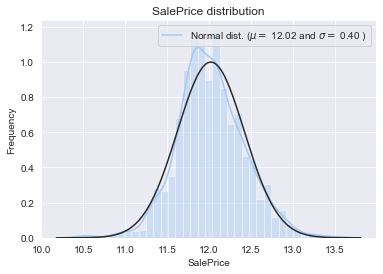

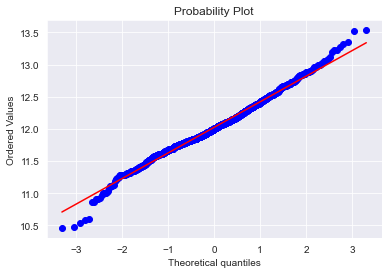

In [39]:
# Distribution plot
sns.distplot(y, fit=norm)

(mu, sigma) = norm.fit(y)
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(y, plot=plt)
plt.show()

### 새로운 feature값 생성

기존 데이터에서 관련성이 높은 변수의 조합이나 비율을 새로 생성하여 feature항목으로 추가한다. 이번에는 집의 크기가 가격의 주요 요소가 될 것이라 생각되어 평방 피트와 관련된 몇 가지 항목만 추가하기로 했다. 

또한, category형 feature이지만 numerical 형 feature로 지정된 일부 변수들을 변환했다.

In [40]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

In [46]:
for table in [df,test]:
    table['MSSubClass'] = table['MSSubClass'].apply(str)
    table['YrSold'] = table['YrSold'].astype(str)
    table['MoSold'] = table['MoSold'].astype(str)

인코딩

In [64]:
qual_dict = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
bsmt_fin_dict = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

for table in [df, test]:
    table['ExterQual'] = table['ExterQual'].map(qual_dict)
    table['ExterCond'] = table['ExterCond'].map(qual_dict)
    table['BsmtQual'] = table['BsmtQual'].map(qual_dict)
    table['BsmtCond'] = table['BsmtCond'].map(qual_dict)
    table['PoolQC'] = table['PoolQC'].map(qual_dict)
    table['HeatingQC'] = table['HeatingQC'].map(qual_dict)
    table['KitchenQual'] = table['KitchenQual'].map(qual_dict)
    table['FireplaceQu'] = table['FireplaceQu'].map(qual_dict)
    table['GarageQual'] = table['GarageQual'].map(qual_dict)
    table['GarageCond'] = table['GarageCond'].map(qual_dict)
    table['BsmtExposure'] = table['BsmtExposure'].map({'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})
    table['BsmtFinType1'] = table['BsmtFinType1'].map(bsmt_fin_dict)
    table['BsmtFinType2'] = table['BsmtFinType2'].map(bsmt_fin_dict)
    table['Functional'] = table['Functional'].map({'none': 0, 'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod':5, 'Min2': 6, 'Min1': 7, 'Typ': 8})
    table["GarageFinish"] = table["GarageFinish"].map({'None': 0, "Unf": 1, "RFn": 2, "Fin": 3})
    table["Fence"] = table["Fence"].map({'None': 0, "MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4})
    table["CentralAir"] = table["CentralAir"].map({'N': 0, "Y": 1})
    table["PavedDrive"] = table["PavedDrive"].map({'N': 0, "P": 1, "Y": 2})    
    table["Street"] = table["Street"].map({'Grvl': 0, "Pave": 1})
    table["Alley"] = table["Alley"].map({'None': 0, "Grvl": 1, "Pave": 2})
    table["LandSlope"] = table["LandSlope"].map({'Gtl': 0, "Mod": 1, "Sev": 2})
    table["LotShape"] = table["LotShape"].map({'Reg': 0, "IR1": 1, "IR2": 2, "IR3": 3})

modified_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual' \
                    ,'FireplaceQu','GarageQual','GarageCond','BsmtExposure','BsmtFinType1' \
                   ,'BsmtFinType2', 'Functional','GarageFinish','Fence','Street','Alley','LandSlope'\
                    ,'PavedDrive' ,'CentralAir','PoolQC','OverallQual','OverallCond','LotShape']

s = (df.dtypes == 'object')
object_cols = list(s[s].index) # TODO df가 포함된 boolean 조건 그 자체는 df이다. s[s]로 True값만으로 구성된 series를 걸러낼 수 있다.
print(object_cols)
print(type(s))
# object_cols = [x for x in object_cols if x not in modified_cols]

['MSSubClass', 'MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
<class 'pandas.core.series.Series'>


### 여러가지 그래프

생략

인코딩 R2